# Projeto ICD - Teste de Hipótese

## Hipótese: Houve Ganhador?

No poker não existe um método absoluto para decidir qual jogador é melhor.<br> 
Os dados que estamos usando inicia cada jogada com o mesmo número de fichas, independente de quanto o jogador ganhou ou perdeu na última jogada, o que possibilita uma análise menos complexa, já que não há o desbalaceamento de fichas.<br>

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize']  = (15, 8)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 4

### Buscando dados no dataset original:

In [2]:
def getPluribusData(): 
    """
    Carrega o arquivo com os dados originais
    """
    pluribus_raw_lines = [] 
    with open('pluribus_entire_raw_data.log', 'rt') as pluribus_file: 
        for file_line in pluribus_file:
            pluribus_raw_lines.append(file_line)
    return pluribus_raw_lines 
        
pluribus_raw_lines  = getPluribusData()

In [3]:
print("Quantidade de jogos: ", len(pluribus_raw_lines))
print("Quantidade de mão jogadas: ", len(pluribus_raw_lines)*6)
print("Exemplo de um jogo: \n  ", pluribus_raw_lines[0])

Quantidade de jogos:  7228
Quantidade de mão jogadas:  43368
Exemplo de um jogo: 
   STATE:0:ffr225fff:3c9s|6d5s|9dTs|2sQs|AdKd|7cTc:-50|-100|0|0|150|0:MrWhite|Gogo|Budd|Eddie|Bill|Pluribus



In [4]:
def getPlays(line):
  """
    A partir da linha inicial de dados do Pluribus,
    separa as informações.
  """
  data = {
          'handIndex' : '',
              'play'  : [],
       'cardsPlayers' : [],
         'cardsTable' : [],
              'bets'  : [],
             'players': []    
  }
  cards = ""

  line = list(line)
  twoPoints = 0
  for currentState in line:
    if (currentState == ':'):
      twoPoints += 1
    elif twoPoints == 1 :
      data['handIndex'] = currentState
    elif twoPoints == 2 :
      data['play'].append(currentState)
    elif twoPoints == 3 :
      cards += currentState
    elif twoPoints == 4 :
      data['bets'].append(currentState)
    elif twoPoints == 5 :
      data['players'].append(currentState)

  #Treating players name
  #data['players'].pop() #Remove '\n'
  if data['players'][-1] == "\n":
    data['players'].pop()
    
  if data['players'][-1] == "E":
    data['players'] = data['players'][:len(data['players'])-5]
  data['players'] = ''.join(data['players']).split('|') #Join the name of the players

  #Treating bets
  data['bets'] = ''.join(data['bets']).split('|') #Join bet values
  data['bets'] = [float(i) for i in data['bets']]

  #Treating Rounds
  data['rounds_quantity'] = data['play'].count('/')
  data['play'] = ''.join(data['play']).split('/')
  

  #Treating Cards:
  if data['rounds_quantity'] == 0:
    data['cardsPlayers'] = cards
  else:
    data['cardsPlayers'], data['cardsTable'] = cards.split('/', 1)

  data['cardsPlayers'] = ''.join(data['cardsPlayers']).split('|')
  data['cardsTable'] = ''.join(data['cardsTable']).split('/')

  return data


In [5]:
game = getPlays(pluribus_raw_lines[7000]) 
print("Jogadores             ", game['players'])
print()
print("Ações:                ", game['play'])
print()
print("Valores ganhos:       ", game['bets'])
print()
print("Cartas dos jogadores: ", game['cardsPlayers'])
print() 
print("Cartas da mesa:       ", game['cardsTable'])  

Jogadores              ['MrPink', 'MrBlue', 'Joe', 'Bill', 'Pluribus', 'MrOrange']

Ações:                 ['ffffr300c', 'r450f']

Valores ganhos:        [300.0, -300.0, 0.0, 0.0, 0.0, 0.0]

Cartas dos jogadores:  ['8s6s', '8c4c', '6c3c', '7h9s', '5cTc', 'Qh3h']

Cartas da mesa:        ['2hAh3d']


#### Analisando quantidade de jogadores

In [6]:
jogadores = []
for line in pluribus_raw_lines:
    game = getPlays(line) 
    jogadores_rodada = game['players']
    for jogador in jogadores_rodada:
        if jogador not in jogadores:
            jogadores.append(jogador)
            
print("Quantidade de jogadores ", len(jogadores))
print("Nomes dos jogadores: \n", jogadores)

Quantidade de jogadores  14
Nomes dos jogadores: 
 ['MrWhite', 'Gogo', 'Budd', 'Eddie', 'Bill', 'Pluribus', 'MrBrown', 'MrBlue', 'MrPink', 'MrOrange', 'MrBlonde', 'Joe', 'ORen', 'Hattori']


Na verdade são codinomes, como são jogadores profissionais de poker os autores evitaram correlacionar as jogadas ao jogador, para não expor estratégias dos mesmos.

#### Criando dataset para analizar vitórias e derrotas

In [7]:
colunas = ['NomeJogador', 'Valor']

jogos_jogadores = []
for line in pluribus_raw_lines:
    game = getPlays(line) 
    for i in range(6):
        temp_dict = {}
        temp_dict['NomeJogador'] = game['players'][i]
        temp_dict['Valor'] = game['bets'][i]
        jogos_jogadores.append(temp_dict)

df_ganhos = pd.DataFrame(jogos_jogadores, columns=colunas)

df_ganhos.head(5)


,NomeJogador,Valor
0,MrWhite,-50.0
1,Gogo,-100.0
2,Budd,0.0
3,Eddie,0.0
4,Bill,150.0


In [8]:
porcentagem_ganho = (df_ganhos[df_ganhos['Valor'] > 0].groupby(['NomeJogador']).size()  / df_ganhos.groupby(['NomeJogador']).size())
porcentagem_ganho

NomeJogador
Bill        0.178010
Budd        0.173534
Eddie       0.170957
Gogo        0.190574
Hattori     0.192308
Joe         0.147883
MrBlonde    0.160968
MrBlue      0.190109
MrBrown     0.165721
MrOrange    0.130133
MrPink      0.167365
MrWhite     0.154235
ORen        0.135135
Pluribus    0.170310
dtype: float64

### Analisando as médias:

In [9]:
media = porcentagem_ganho.mean()
variancia =  porcentagem_ganho.var()
raiz_n = (porcentagem_ganho.size)**.5
print("Média: ", media)
print("Variância ", variancia)
print("Raiz de n: ", raiz_n)

Média:  0.16623146942796607
Variância  0.0003733541456853374
Raiz de n:  3.7416573867739413


#### Calculado Intervalo de Confiança por erro padrão

In [10]:
inferior = media - 1.96* (variancia/raiz_n)
superior =  media + 1.96* (variancia/raiz_n)
print("Intervalo inferior de verificação com 2,5%: ", inferior)
print("Intervalo superior de verificação com 97,5%: ", superior)

Intervalo inferior de verificação com 2,5%:  0.166035894566374
Intervalo superior de verificação com 97,5%:  0.16642704428955815


Sendo que são seis jogadores na mesa, a nossa média de ganho randomizada é de 1/6 e vemos com o intervalo acima que essa média se mantém para os jogos.

## Criando IC com Bootstrap para analisar prováveis ganhadores: 

Trabalharemos com um intervalo superior de 99,9% para garantir maior precisão em nossa análise.

#### Criando distribuição com chance de ganho aleatório e definindo intervalo superior de confiança:

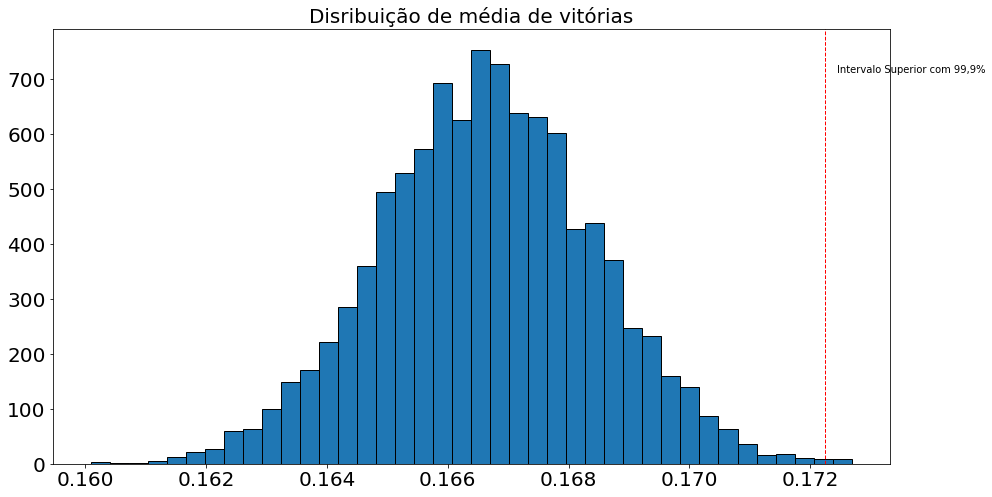

In [14]:
distribuicao = []
for i in range(10000):
    temp = np.random.randint(0,6,size=43368)
    x = (temp == 1).sum() / 43368
    distribuicao.append(x)

superior = np.percentile(distribuicao, 99.9)

plt.hist(distribuicao, bins=40, edgecolor = 'k')
plt.axvline(superior, color='r', linestyle='dashed', linewidth=1)
plt.title('Disribuição de média de vitórias')
min_ylim, max_ylim = plt.ylim()
plt.text(superior+0.0002, max_ylim*0.9, 'Intervalo Superior com 99,9%')
plt.show()


<br>

**Gerando um gráfico diferenciando os jogadores que ganharam dos que perderam a partir do intervalo de confiança calculado:**

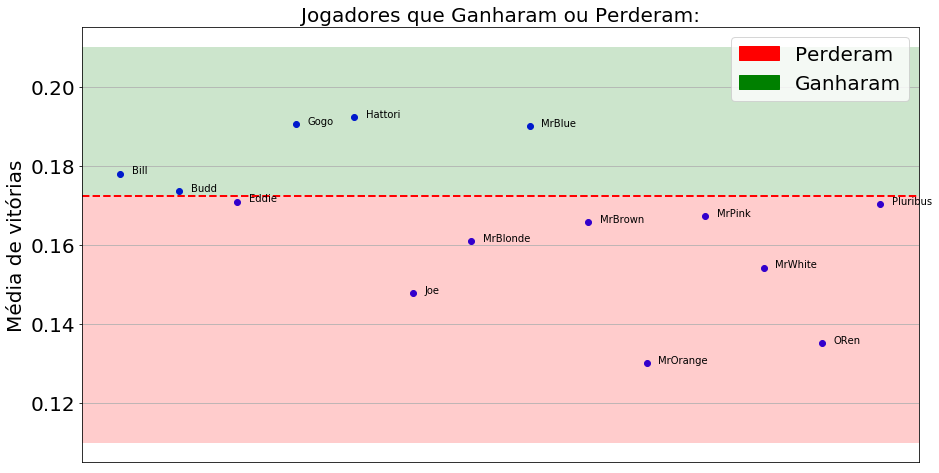

In [15]:

x_img_data = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5]
plt.scatter(x_img_data, porcentagem_ganho.values, color='b', alpha=1)
plt.xticks(rotation=45)

 
for i, txt in enumerate(porcentagem_ganho.index):
    plt.annotate(txt, (x_img_data[i]+0.1, porcentagem_ganho.values[i]))
    
plt.axhspan(0.11, superior, facecolor='red', alpha=0.2)
plt.axhspan(superior, 0.21, facecolor='green', alpha=0.2)

plt.axhline(superior, color='r', linestyle='dashed', linewidth=2)

ax = plt.gca()
ax.axes.get_xaxis().set_visible(False)
ax.grid(True)

import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

red_patch = mpatches.Patch(color='red', label='Perderam')
green_patch = mpatches.Patch(color='green', label='Ganharam')
plt.legend(handles=[red_patch, green_patch])

plt.title('Jogadores que Ganharam ou Perderam:')
plt.ylabel('Média de vitórias')

plt.show()